In [2]:
import matplotlib.pyplot as plt
import numpy as np

## MAPE bar chart

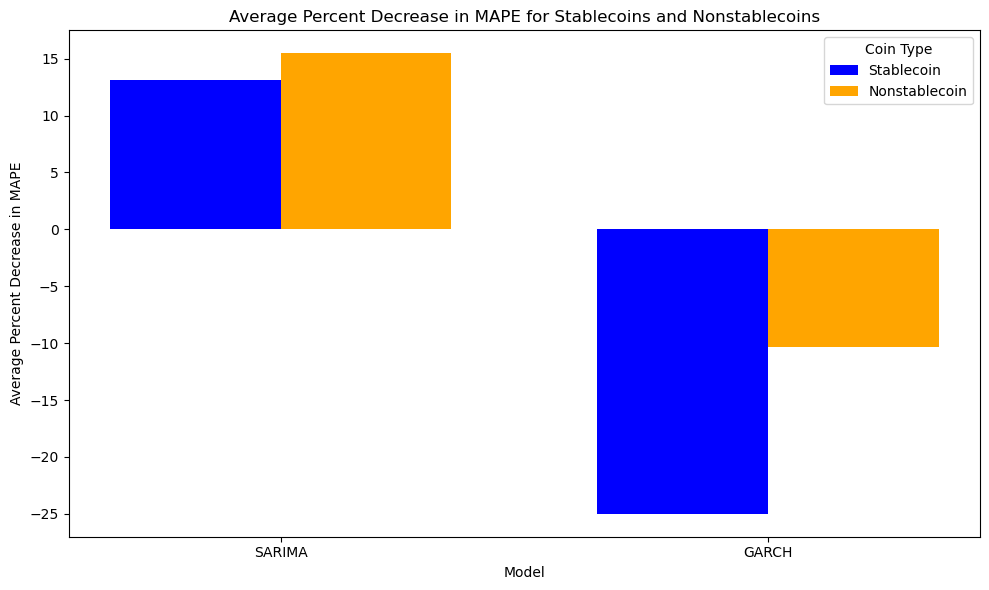

In [4]:
labels = ['SARIMA', 'GARCH']
stable = [13.10783828, -24.99222125]
nonstable = [15.47012792, -10.334692]

x = np.arange(len(labels))  # [0, 1]
width = 0.35

# Plotting
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, stable, width, label='Stablecoin', color='blue')
bars2 = plt.bar(x + width/2, nonstable, width, label='Nonstablecoin', color='orange')

# Labels and Title
plt.xticks(x, labels)
plt.xlabel('Model')
plt.ylabel('Average Percent Decrease in MAPE')
plt.title('Average Percent Decrease in MAPE for Stablecoins and Nonstablecoins')
plt.legend(title='Coin Type')
plt.tight_layout()
plt.show()


## 5% Error Calculations

In [224]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
import sklearn
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from sklearn.preprocessing import StandardScaler
from arch import arch_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error


# Load data
df = pd.read_excel('data/PCA Mastersheet.xlsx')
print(df.head())
print(df.columns.tolist())

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

       Month    PC1_macro     PC2_macro   Tether  USD Coin  PC1_crypto  \
0 2017-09-01  6067.698298 -18663.045363 -3.82830       NaN         NaN   
1 2017-10-01  6152.013916 -18689.272033 -3.73861       NaN         NaN   
2 2017-11-01  6143.421303 -18828.738277 -4.01951       NaN         NaN   
3 2017-12-01  6193.529376 -18878.593243 -2.55687       NaN         NaN   
4 2018-01-01  6243.197778 -18931.069455 -2.75193       NaN         NaN   

   PC2_crypto  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
['Month', 'PC1_macro', 'PC2_macro', 'Tether', 'USD Coin', 'PC1_crypto', 'PC2_crypto']


In [225]:
## Testing all combinations

macro_list = ['PC1_macro', 'PC2_macro']
asset_list= ['Tether', 'USD Coin','PC1_crypto','PC2_crypto']

In [226]:
from arch import arch_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

def rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q, l):
    history = list(y_train_scaled)
    preds = []

    for t in range(len(y_test_scaled)):
        model = arch_model(history, mean='AR', lags=l, vol='GARCH', p=p, q=q, dist='normal', rescale=False)
        res = model.fit(disp='off')
        forecast = res.forecast(horizon=1, method='analytic')
        pred = forecast.mean.values[-1, 0]
        preds.append(pred)
        history.append(y_test_scaled[t])

    return np.array(preds)

def rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, p, q, l):
    history_y = list(y_train_scaled)
    history_x = list(x_train_scaled)
    preds = []

    for t in range(len(y_test_scaled)):
        # Ensure x is 1D (required for arch_model)
        x_arr = np.array(history_x).reshape(-1)

        try:
            model = arch_model(
                history_y,
                mean='ARX',
                lags=l,
                vol='GARCH',
                p=p,
                q=q,
                x=x_arr,
                dist='normal',
                rescale=False
            )
            res = model.fit(disp='off')

            const = res.params.get('Const', 0)
            phi = res.params.get('y[1]', 0)
            beta = res.params.get('x0', 0)

            y_t = history_y[-1]
            x_t1 = float(x_test_scaled[t])

            pred = const + phi * y_t + beta * x_t1
            preds.append(pred)

            history_y.append(y_test_scaled[t])
            history_x.append(x_t1)

        except Exception as e:
            print(f"[{t}] Rolling ARX error: {e}")
            preds.append(np.nan)
            history_y.append(y_test_scaled[t])
            history_x.append(float(x_test_scaled[t]))

    return np.array(preds)


In [227]:
def rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q,l):
    history = list(y_train_scaled)
    preds = []

    for t in range(len(y_test_scaled)):
        model = arch_model(history, mean='AR', lags=l, vol='GARCH', p=p, q=q, dist='normal')
        res = model.fit(disp='off')
        forecast = res.forecast(horizon=1, method='analytic')
        pred = forecast.mean.values[-1, 0]
        preds.append(pred)
        history.append(y_test_scaled[t]) 

    return np.array(preds)

In [228]:
def plot_garch_mean_predictions_rolling(df, macro, asset, y_col, p, q, l, title_suffix=""):
    from sklearn.preprocessing import StandardScaler
    import numpy as np
    import matplotlib.pyplot as plt
    from arch import arch_model

    # 1) Prepare data
    df_temp = df[[y_col, asset]].dropna().copy()
    if len(df_temp) < 30:
        print(f"Skipping {macro}-{asset}: insufficient data ({len(df_temp)})")
        return

    train_size = int(len(df_temp) * 0.85)
    df_train   = df_temp.iloc[:train_size]
    df_test    = df_temp.iloc[train_size:]

    # 2) Scale y and x
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()

    y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
    x_train_scaled = scaler_x.fit_transform(df_train[[asset]]).flatten()
    y_test_scaled  = scaler_y.transform(df_test[[y_col]]).flatten()
    x_test_scaled  = scaler_x.transform(df_test[[asset]]).flatten()

    try:
        # 3) Rolling AR forecast
        history = list(y_train_scaled)
        preds_ar = []
        for t in range(len(y_test_scaled)):
            m = arch_model(history, mean='AR', lags=l, vol='GARCH',
                           p=p, q=q, dist='normal', rescale=False)
            res = m.fit(disp='off')
            f  = res.forecast(horizon=1, method='analytic')
            preds_ar.append(f.mean.values[-1, 0])
            history.append(y_test_scaled[t])
        preds_ar = np.array(preds_ar)

        # 4) Rolling ARX forecast
        history_y = list(y_train_scaled)
        history_x = list(x_train_scaled)
        preds_arx = []
        for t in range(len(y_test_scaled)):
            x_arr = np.array(history_x).reshape(-1)
            m = arch_model(history_y, mean='ARX', lags=l, vol='GARCH',
                           p=p, q=q, x=x_arr, dist='normal', rescale=False)
            res = m.fit(disp='off')
            # build one‐step ARX prediction: const + phi·yₜ + β·xₜ₊₁
            const = res.params.get('Const', 0)
            phi   = res.params.get('y[1]',   0)
            beta  = res.params.get('x0',     0)
            y_t   = history_y[-1]
            x_t1  = float(x_test_scaled[t])
            preds_arx.append(const + phi*y_t + beta*x_t1)
            history_y.append(y_test_scaled[t])
            history_x.append(x_t1)
        preds_arx = np.array(preds_arx)

        # 5) Inverse‐scale forecasts & actuals
        pred_ar_level  = scaler_y.inverse_transform(preds_ar.reshape(-1,1)).flatten()
        pred_arx_level = scaler_y.inverse_transform(preds_arx.reshape(-1,1)).flatten()
        y_actual_level = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()
        index_test = df_test.index

        # +/- 5% band around the actual values
        lower_band = y_actual_level * 0.95
        upper_band = y_actual_level * 1.05

        def check_within_band(predictions, lower_band, upper_band):
            return (predictions >= lower_band) & (predictions <= upper_band)

        inside_ar = check_within_band(pred_ar_level, lower_band, upper_band)
        inside_arx = check_within_band(pred_arx_level, lower_band, upper_band)

        # Print results
        print("Date       | AR Inside Band | ARX Inside Band")
        print("----------- | --------------- | ----------------")
        for date, ar_ok, arx_ok in zip(index_test, inside_ar, inside_arx):
            print(f"{date.date()} | {ar_ok!s:5} | {arx_ok!s:5}")

        pct_ar_inside  = inside_ar.mean() * 100
        pct_arx_inside = inside_arx.mean() * 100
        print()
        print(f"AR     forecasts inside ±5% band: {pct_ar_inside:.1f}% of the time")
        print(f"ARX+GARCH forecasts inside ±5% band: {pct_arx_inside:.1f}% of the time")

        # plotting band on same plot
        plt.figure(figsize=(10, 5))
        plt.fill_between(
            index_test,
            lower_band,
            upper_band,
            color='gray',
            alpha=0.3,
            label='±5% error threshold'
        )

        plt.plot(index_test, y_actual_level, label='Actual (Test)', color='black', marker='o')
        plt.plot(index_test, pred_ar_level, label='AR', linestyle='--', marker='x')
        plt.plot(index_test, pred_arx_level, label='ARX', linestyle='--', marker='s')
        plt.title(f'{macro}-{asset} GARCH Mean Rolling Forecasts {title_suffix}')
        plt.xlabel('Time')
        plt.ylabel(y_col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Plotting failed for {macro}-{asset}: {e}")

        plt.figure(figsize=(10,5))
        plt.plot(index_test, y_actual_level,   'o-', color='black',  label='Actual')
        plt.plot(index_test, pred_ar_level,    'x--', color='blue',   label='AR Forecast')
        plt.plot(index_test, pred_arx_level,   's--', color='orange', label='ARX Forecast')
        plt.title(f"{macro}-{asset} GARCH Mean Rolling Forecasts {title_suffix}")
        plt.xlabel("Time")
        plt.ylabel(y_col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
 

In [229]:
print(df.columns.tolist())


['PC1_macro', 'PC2_macro', 'Tether', 'USD Coin', 'PC1_crypto', 'PC2_crypto']


Date       | AR Inside Band | ARX Inside Band
----------- | --------------- | ----------------
2024-01-01 | True  | True 
2024-02-01 | True  | True 
2024-03-01 | True  | True 
2024-04-01 | True  | True 
2024-05-01 | True  | True 
2024-06-01 | True  | True 
2024-07-01 | True  | True 
2024-08-01 | True  | True 
2024-09-01 | True  | True 
2024-10-01 | True  | True 
2024-11-01 | True  | True 
2024-12-01 | True  | True 
2025-01-01 | True  | True 

AR     forecasts inside ±5% band: 100.0% of the time
ARX+GARCH forecasts inside ±5% band: 100.0% of the time


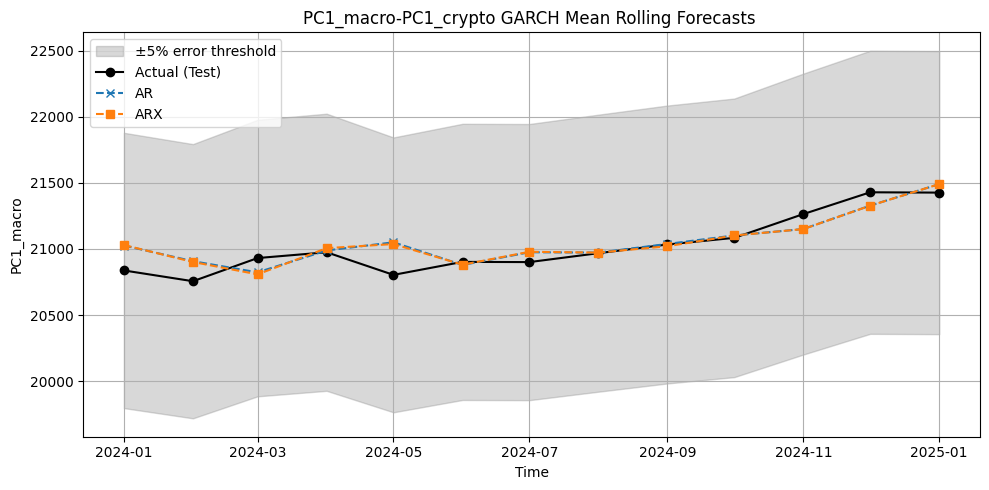

In [230]:
plot_garch_mean_predictions_rolling(
    df=df,
    macro='PC1_macro',
    asset='PC1_crypto',
    y_col='PC1_macro',
    p=1, q=1, l=1,
    title_suffix=""
)

Date       | AR Inside Band | ARX Inside Band
----------- | --------------- | ----------------
2024-01-01 | True  | True 
2024-02-01 | True  | True 
2024-03-01 | True  | True 
2024-04-01 | True  | True 
2024-05-01 | True  | True 
2024-06-01 | True  | True 
2024-07-01 | True  | True 
2024-08-01 | True  | True 
2024-09-01 | True  | True 
2024-10-01 | True  | True 
2024-11-01 | True  | True 
2024-12-01 | True  | True 
2025-01-01 | True  | True 

AR     forecasts inside ±5% band: 100.0% of the time
ARX+GARCH forecasts inside ±5% band: 100.0% of the time


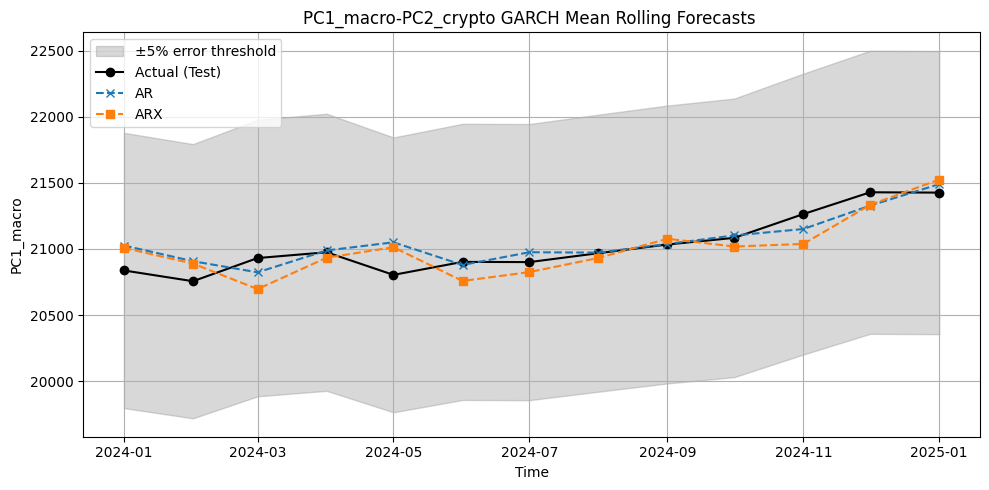

In [231]:
plot_garch_mean_predictions_rolling(
    df=df,
    macro='PC1_macro',
    asset='PC2_crypto',
    y_col='PC1_macro',
    p=1, q=1, l=1,
    title_suffix=""
)

Date       | AR Inside Band | ARX Inside Band
----------- | --------------- | ----------------
2024-01-01 | False | False
2024-02-01 | False | False
2024-03-01 | False | False
2024-04-01 | False | False
2024-05-01 | False | False
2024-06-01 | False | False
2024-07-01 | False | False
2024-08-01 | False | False
2024-09-01 | False | False
2024-10-01 | False | False
2024-11-01 | False | False
2024-12-01 | False | False
2025-01-01 | False | False

AR     forecasts inside ±5% band: 0.0% of the time
ARX+GARCH forecasts inside ±5% band: 0.0% of the time


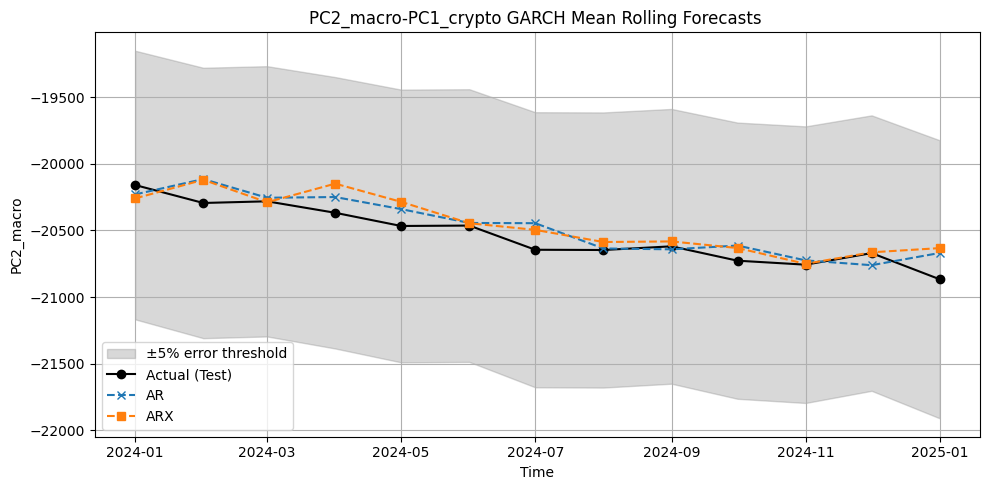

In [232]:
plot_garch_mean_predictions_rolling(
    df=df,
    macro='PC2_macro',
    asset='PC1_crypto',
    y_col='PC2_macro',
    p=1, q=1, l=1,
    title_suffix=""
)

Date       | AR Inside Band | ARX Inside Band
----------- | --------------- | ----------------
2024-01-01 | False | False
2024-02-01 | False | False
2024-03-01 | False | False
2024-04-01 | False | False
2024-05-01 | False | False
2024-06-01 | False | False
2024-07-01 | False | False
2024-08-01 | False | False
2024-09-01 | False | False
2024-10-01 | False | False
2024-11-01 | False | False
2024-12-01 | False | False
2025-01-01 | False | False

AR     forecasts inside ±5% band: 0.0% of the time
ARX+GARCH forecasts inside ±5% band: 0.0% of the time


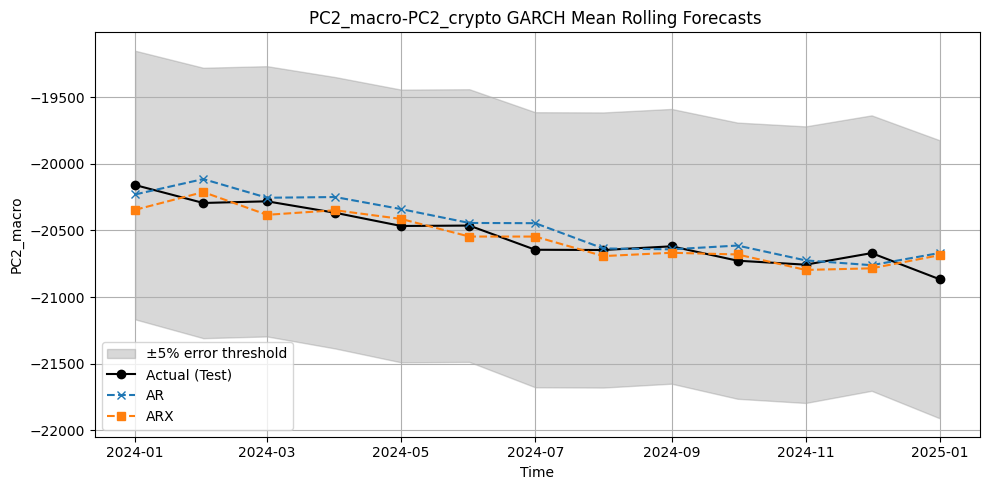

In [233]:
plot_garch_mean_predictions_rolling(
    df=df,
    macro='PC2_macro',
    asset='PC2_crypto',
    y_col='PC2_macro',
    p=1, q=1, l=1,
    title_suffix=""
)

## SARIMA/X error graphs

In [234]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML

# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

In [235]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP Monthly', 'IM', 'EX', 'CC', 'CC Monthly % Change', 'VIX', 'MOVE']
vol_macro_list = ['vol_LFPR', 'vol_CPI', 'vol_r', 'vol_M1', 'vol_GDP', 'vol_IM', 'vol_EX', 'vol_CC']
asset_list= ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin', 'Bitcoin Price']
pc_list = ['PC1_macro', 'PC2_macro']
train_end = '2024-01-01'

In [236]:
ar_orders = {}
ar_orders['LFPR'] = {'p': 1, 'd': 1,'q': 0, 'P': 1, 'D': 1, 'Q': 0, 'lag': 1}
ar_orders['CPI'] = {'p': 1, 'd': 2,'q': 0, 'P': 1, 'D': 1, 'Q': 0, 'lag': 0}
ar_orders['r'] = {'p': 1, 'd': 2,'q': 0, 'P': 1, 'D': 0, 'Q': 0, 'lag': 0}
ar_orders['M1'] = {'p': 1, 'd': 1,'q': 0, 'P': 1, 'D': 0, 'Q': 1, 'lag': 1}
ar_orders['GDP Monthly'] = {'p': 1, 'd': 1,'q': 0, 'P': 1, 'D': 1, 'Q': 0, 'lag':0}
ar_orders['IM'] = {'p': 1, 'd': 1,'q': 1, 'P': 2, 'D': 1, 'Q': 0, 'lag':0}
ar_orders['EX'] = {'p': 1, 'd': 1,'q': 0, 'P': 1, 'D': 1, 'Q': 0, 'lag':1}
ar_orders['CC'] = {'p': 2, 'd': 1,'q': 0, 'P': 1, 'D': 1, 'Q': 1, 'lag':0}
ar_orders['CC Monthly % Change'] = {'p': 2, 'd': 0,'q': 0, 'P': 2, 'D': 1, 'Q': 0, 'lag':3}
ar_orders['VIX'] = {'p': 1, 'd': 0,'q': 0, 'P': 1, 'D': 1, 'Q': 0, 'lag':0}
ar_orders['MOVE'] = {'p': 1, 'd': 1,'q': 0, 'P': 1, 'D': 0, 'Q': 0, 'lag':6}

ar_orders['PC1_macro'] = {'p': 1, 'd': 1,'q': 1, 'P': 1, 'D': 1, 'Q': 0, 'lag':2}
ar_orders['PC2_macro'] = {'p': 1, 'd': 1,'q': 1, 'P': 1, 'D': 1, 'Q': 0, 'lag':0}

ar_orders['vol_LFPR'] = {'p': 1, 'd': 1,'q': 0}
ar_orders['vol_CPI'] = {'p': 1, 'd': 1, 'q': 0}
ar_orders['vol_r'] = {'p': 1, 'd': 1,'q': 0}
ar_orders['vol_M1'] = {'p': 1, 'd': 1,'q': 0}
ar_orders['vol_GDP'] = {'p': 1, 'd': 1, 'q': 0}
ar_orders['vol_IM'] = {'p': 1, 'd': 2,'q': 0}
ar_orders['vol_EX'] = {'p': 1, 'd': 1, 'q': 0}
ar_orders['vol_CC'] = {'p': 1, 'd': 1,'q': 0}

In [237]:
def run_model(df, macro, asset, plot):
    df_temp = df[[macro, asset]].dropna().copy()
    order_dict = ar_orders.get(macro, {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D':1, 'Q':0, 'lag': 0})  # Default to AR(1) if macro not found

    p = order_dict['p']
    d = order_dict['d']
    q = order_dict['q']
    P = order_dict['P']
    D = order_dict['D']
    Q = order_dict['Q']
    asset_lag = order_dict['lag']

    # Asset lag
    for lag in range(1, asset_lag + 1):
        df_temp[f'{asset}_lag{lag}'] = df_temp[asset].shift(lag)
    exog_cols = [asset] + [f'{asset}_lag{lag}' for lag in range(1, asset_lag + 1)]

    exog = df_temp[exog_cols].dropna()
    target = df_temp.loc[exog.index, macro]

    # Train/test split
    train_endog = target[:train_end]
    train_exog = exog[:train_end]
    test_endog = target[train_end:]
    test_exog = exog[train_end:]

    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)
        ar_model = SARIMAX(train_endog, order=(p, d, q), seasonal_order = (P, D, Q, 12))
        ar_result = ar_model.fit(disp=False)
        arx_model = SARIMAX(train_endog, exog = train_exog, order=(p, d, q), seasonal_order = (P, D, Q, 12))
        arx_result = arx_model.fit(disp=False)
        # Check for convergence warnings
        for warning in w:
            if issubclass(warning.category, ConvergenceWarning):
                print(f"[WARNING] Convergence issue in macro: {macro}, asset: {asset}")

    # AR model
    forecast_ar = ar_result.get_forecast(steps=len(test_endog))
    pred_ar = forecast_ar.predicted_mean
    conf_int_ar = forecast_ar.conf_int() 

    # ARX model
    forecast_arx = arx_result.get_forecast(steps=len(test_endog), exog=test_exog)
    pred_arx = forecast_arx.predicted_mean
    conf_int_arx = forecast_arx.conf_int()

    pred_ar.index = test_endog.index
    pred_arx.index = test_endog.index
    conf_int_ar.index = test_endog.index
    conf_int_arx.index = test_endog.index

    # print(ar_result.summary())
    # print(arx_result.summary())

    # +/- 5% band around the actual values
    full_lower = target * 0.95
    full_upper = target * 1.05

    lower_band = full_lower.loc[test_endog.index]
    upper_band = full_upper.loc[test_endog.index]

    def check_within_band(predictions, lower_band, upper_band):
        return (predictions >= lower_band) & (predictions <= upper_band)

    inside_ar = check_within_band(pred_ar, lower_band, upper_band)
    inside_arx = check_within_band(pred_arx, lower_band, upper_band)

    # Print results
    print("Date       | AR Inside Band | ARX Inside Band")
    print("----------- | --------------- | ----------------")
    for date, ar_ok, arx_ok in zip(test_endog.index, inside_ar, inside_arx):
        print(f"{date.date()} | {ar_ok!s:5} | {arx_ok!s:5}")

    pct_ar_inside  = inside_ar.mean() * 100
    pct_arx_inside = inside_arx.mean() * 100
    print()
    print(f"AR     forecasts inside ±5% band: {pct_ar_inside:.1f}% of the time")
    print(f"ARX+GARCH forecasts inside ±5% band: {pct_arx_inside:.1f}% of the time")
        

    if plot == True:
        plt.figure(figsize=(10, 5))
        plt.fill_between(
            test_endog.index,
            lower_band,
            upper_band,
            color='gray',
            alpha=0.3,
            label='±5% error threshold'
        )
        plt.plot(target, label='Actual ' + macro, color = 'black')
        plt.plot(pred_ar, label='Forecasted ' + macro+ f' (AR {macro} only)', linestyle='--', color = 'blue')
        plt.fill_between(
            pred_ar.index,
            conf_int_ar.iloc[:, 0],  # Lower bound
            conf_int_ar.iloc[:, 1],   # Upper bound
            color='blue',
            alpha=0.1,
            label='AR 95% CI'
        )
        plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--', color = 'red')
        plt.fill_between(
            pred_arx.index,
            conf_int_arx.iloc[:, 0],  # Lower bound
            conf_int_arx.iloc[:, 1],  # Upper bound
            color='red',
            alpha=0.1,
            label='ARX 95% CI'
        )
        plt.title("Out-of-Sample Forecast")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot only test data with forecasts
        plt.figure(figsize=(10, 5))
        plt.fill_between(
            test_endog.index,
            lower_band,
            upper_band,
            color='gray',
            alpha=0.3,
            label='±5% error threshold'
        )
        plt.plot(test_endog, label='Actual ' + macro, marker='o', color = 'black')
        plt.plot(pred_ar, label='Forecasted ' + macro+ f' (AR {macro} only)', linestyle='--', marker='x', color = 'blue')
        plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--', marker='s', color = 'red')
        plt.title("Forecast vs Actual (Test Period Only)")
        plt.xlabel("Date")
        plt.ylabel(macro)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Metrics
    metrics = [
        {
            'Model': 'AR',
            'MAE': mean_absolute_error(test_endog, pred_ar),
            'RMSE': np.sqrt(mean_squared_error(test_endog, pred_ar)),
            'R2': r2_score(test_endog, pred_ar),
            'MAPE (%)': mean_absolute_percentage_error(test_endog, pred_ar) * 100,
            'Order': f'({p},{d},{q})'
        },
        {
            'Model': 'ARX',
            'MAE': mean_absolute_error(test_endog, pred_arx),
            'RMSE': np.sqrt(mean_squared_error(test_endog, pred_arx)),
            'R2': r2_score(test_endog, pred_arx),
            'MAPE (%)': mean_absolute_percentage_error(test_endog, pred_arx) * 100,
            'Order': f'({p},{d},{q})'
        }
    ]
    df_metrics = pd.DataFrame(metrics).set_index('Model')

    # Display the table
    # print(f"\nModel Performance Comparison for Macro: {macro}, Asset: {asset}")
    # print(df_metrics[['MAE', 'RMSE', 'R2', 'MAPE']])
    
    return df_metrics 

Date       | AR Inside Band | ARX Inside Band
----------- | --------------- | ----------------
2024-01-01 | True  | True 
2024-02-01 | True  | True 
2024-03-01 | True  | True 
2024-04-01 | True  | False
2024-05-01 | True  | True 
2024-06-01 | True  | True 
2024-07-01 | True  | True 
2024-08-01 | False | False
2024-09-01 | False | False
2024-10-01 | False | True 
2024-11-01 | False | False
2024-12-01 | False | False
2025-01-01 | False | False

AR     forecasts inside ±5% band: 53.8% of the time
ARX+GARCH forecasts inside ±5% band: 53.8% of the time


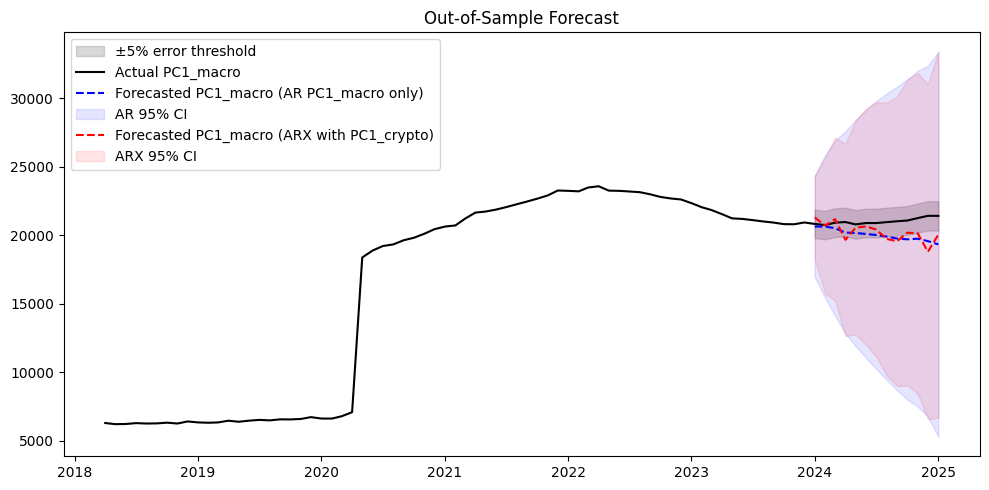

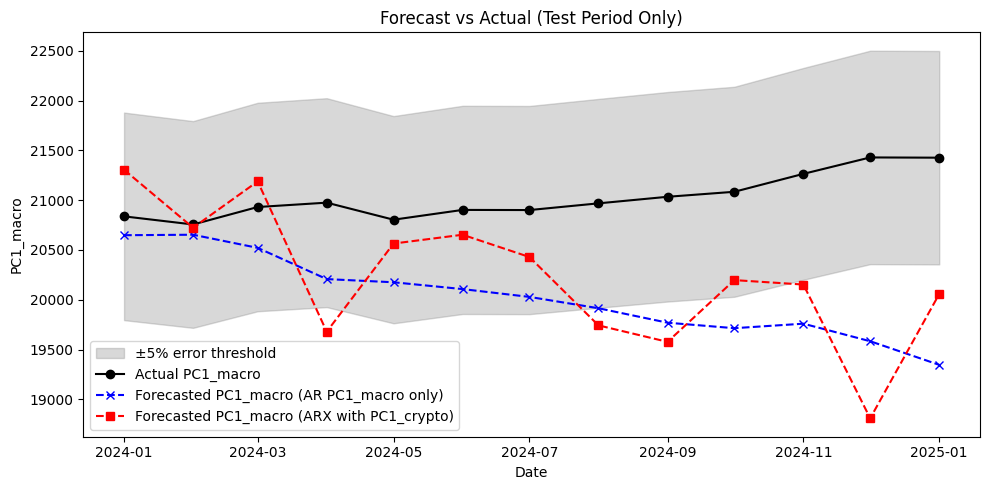

,MAE,RMSE,R2,MAPE (%),Order
Model,,,,,
AR,990.817409,1149.122526,-28.257833,4.687380,"(1,1,1)"
ARX,898.482497,1132.844615,-27.434799,4.247237,"(1,1,1)"


In [238]:
macro = 'PC1_macro'
asset = 'PC1_crypto'
run_model(df.copy(), macro, asset, plot=True)

Date       | AR Inside Band | ARX Inside Band
----------- | --------------- | ----------------
2024-01-01 | True  | False
2024-02-01 | True  | True 
2024-03-01 | True  | False
2024-04-01 | True  | False
2024-05-01 | True  | False
2024-06-01 | True  | False
2024-07-01 | True  | False
2024-08-01 | False | False
2024-09-01 | False | False
2024-10-01 | False | False
2024-11-01 | False | False
2024-12-01 | False | False
2025-01-01 | False | False

AR     forecasts inside ±5% band: 53.8% of the time
ARX+GARCH forecasts inside ±5% band: 7.7% of the time


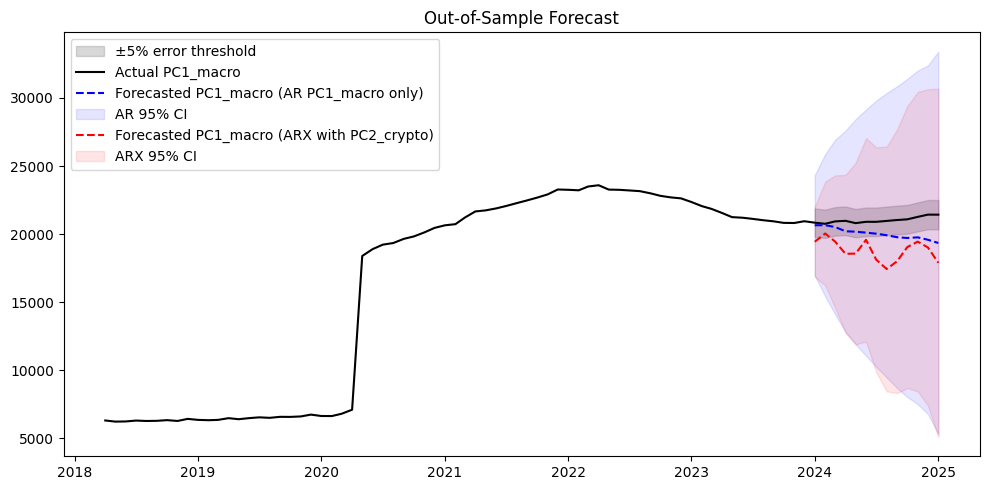

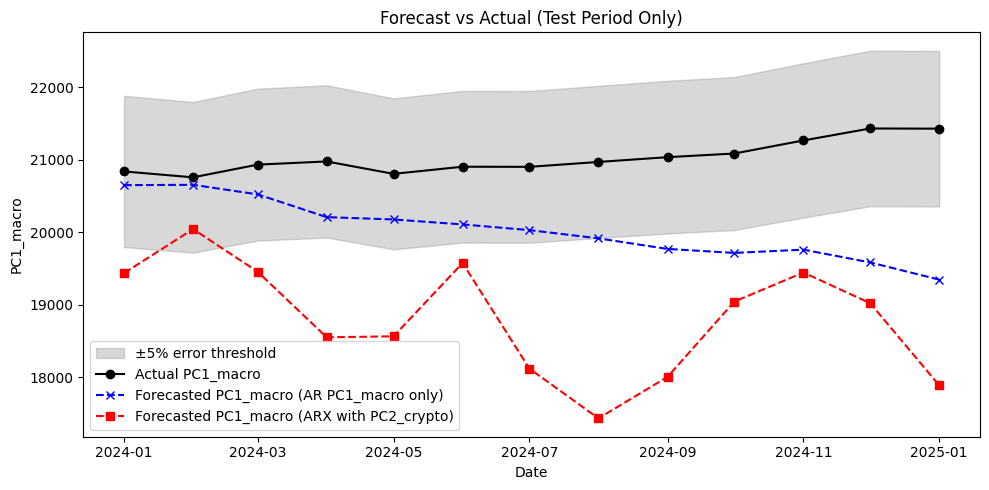

,MAE,RMSE,R2,MAPE (%),Order
Model,,,,,
AR,990.817409,1149.122526,-28.257833,4.687380,"(1,1,1)"
ARX,2209.130361,2360.370999,-122.444010,10.489996,"(1,1,1)"


In [239]:
macro = 'PC1_macro'
asset = 'PC2_crypto'
run_model(df.copy(), macro, asset, plot=True)

Date       | AR Inside Band | ARX Inside Band
----------- | --------------- | ----------------
2024-01-01 | False | False
2024-02-01 | False | False
2024-03-01 | False | False
2024-04-01 | False | False
2024-05-01 | False | False
2024-06-01 | False | False
2024-07-01 | False | False
2024-08-01 | False | False
2024-09-01 | False | False
2024-10-01 | False | False
2024-11-01 | False | False
2024-12-01 | False | False
2025-01-01 | False | False

AR     forecasts inside ±5% band: 0.0% of the time
ARX+GARCH forecasts inside ±5% band: 0.0% of the time


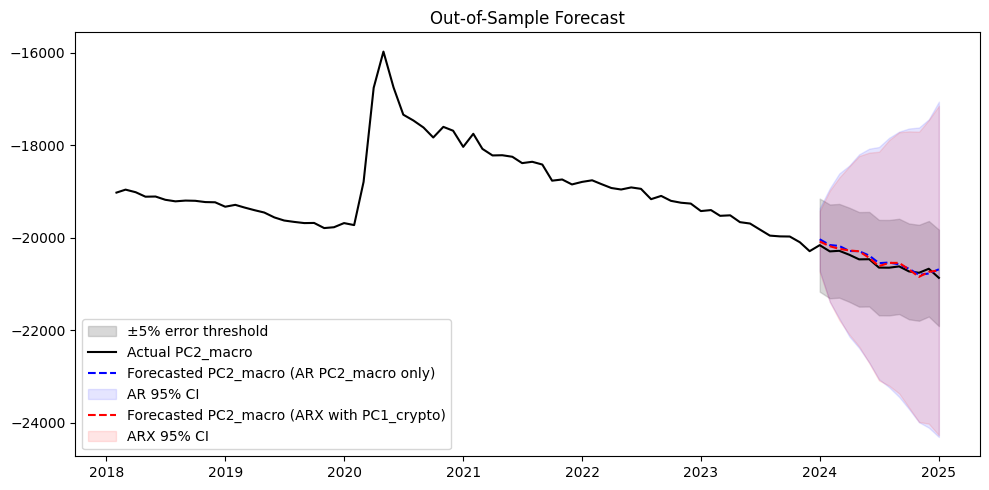

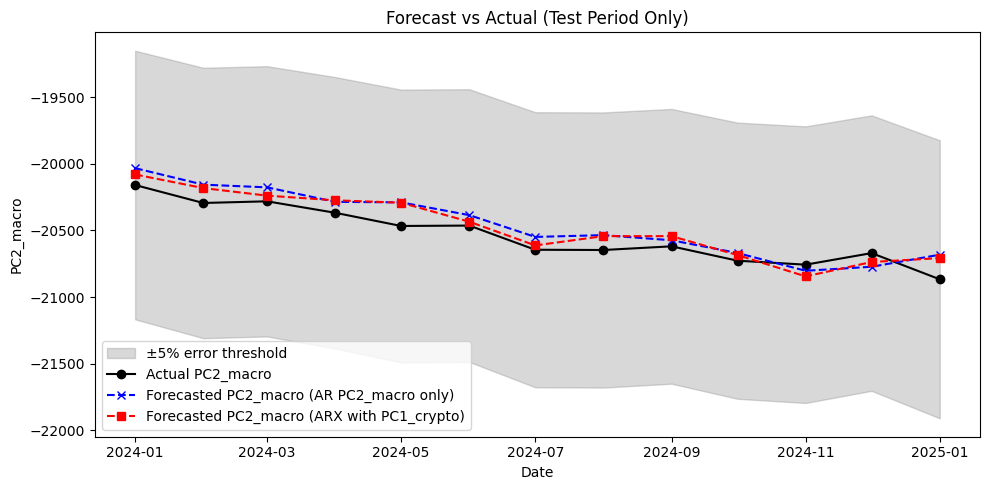

,MAE,RMSE,R2,MAPE (%),Order
Model,,,,,
AR,103.878414,112.311038,0.700490,0.506193,"(1,1,1)"
ARX,84.581340,95.133602,0.785101,0.411675,"(1,1,1)"


In [240]:
macro = 'PC2_macro'
asset = 'PC1_crypto'
run_model(df.copy(), macro, asset, plot=True)

[WARNING] Convergence issue in macro: PC2_macro, asset: PC2_crypto
Date       | AR Inside Band | ARX Inside Band
----------- | --------------- | ----------------
2024-01-01 | False | False
2024-02-01 | False | False
2024-03-01 | False | False
2024-04-01 | False | False
2024-05-01 | False | False
2024-06-01 | False | False
2024-07-01 | False | False
2024-08-01 | False | False
2024-09-01 | False | False
2024-10-01 | False | False
2024-11-01 | False | False
2024-12-01 | False | False
2025-01-01 | False | False

AR     forecasts inside ±5% band: 0.0% of the time
ARX+GARCH forecasts inside ±5% band: 0.0% of the time


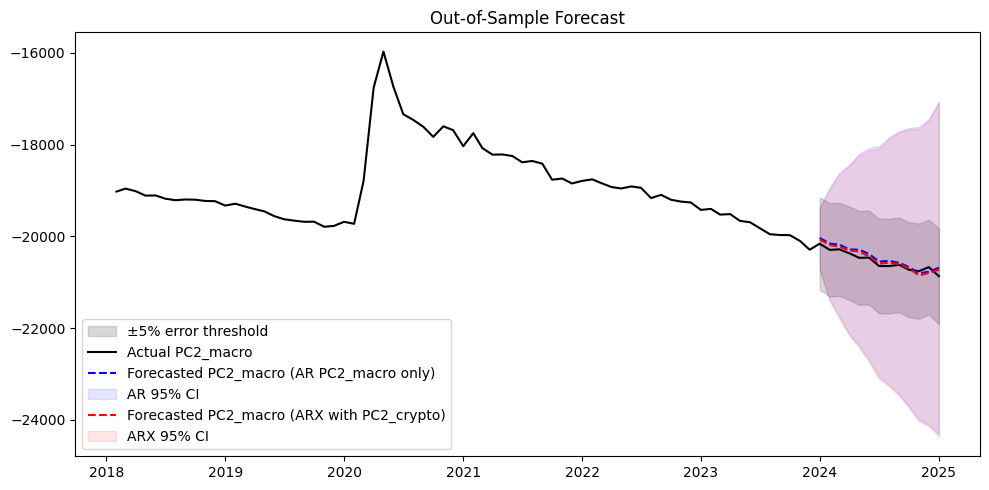

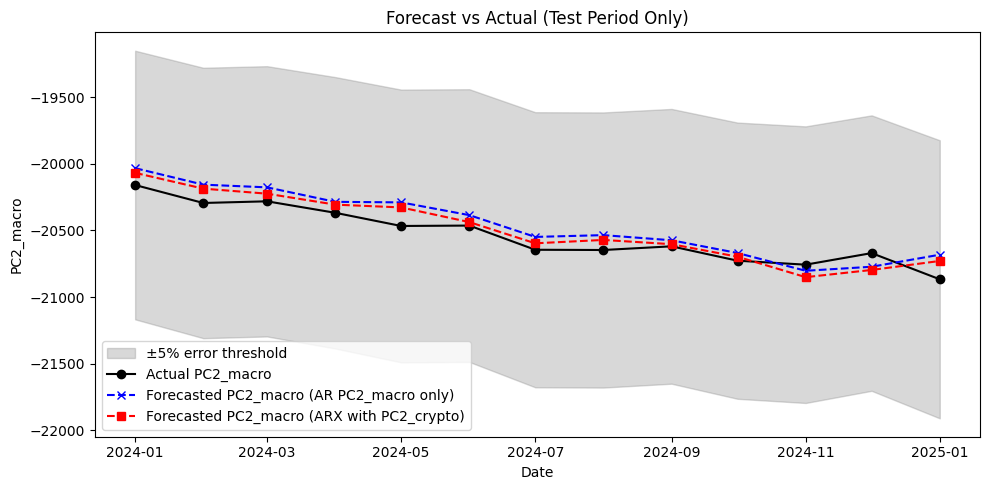

,MAE,RMSE,R2,MAPE (%),Order
Model,,,,,
AR,103.878414,112.311038,0.700490,0.506193,"(1,1,1)"
ARX,77.730217,87.676465,0.817471,0.378419,"(1,1,1)"


In [241]:
macro = 'PC2_macro'
asset = 'PC2_crypto'
run_model(df.copy(), macro, asset, plot=True)